<a href="https://colab.research.google.com/github/shubh-garg18/pair-trading-algorithm/blob/main/Pair_Trading_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Imports and Setup
This section includes the installation of the `yfinance` library and the importation of essential libraries for statistical analysis, data manipulation, and visualization. The environment is configured for the pairs trading algorithm.

In [59]:
!pip install yfinance
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import yfinance as yf
import statsmodels.formula.api as sm
from itertools import combinations

## Define Tickers and Parameters
Defines tickers for bank stocks, global indexes, and tech stocks, along with parameters like start and end dates, p-value threshold, and transaction cost. Loads historical stock price data for the defined tickers and time period.

In [321]:
# Define tickers and parameters
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', 'BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100', '^RUT', '^VIX', '^TNX']
tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'NFLX', 'ADBE', 'ORCL', 'CSCO', 'INTC', 'AMD', 'IBM', 'CRM', 'QCOM', 'TXN', 'SAP']


Tickers = bank_stocks + tech_stocks + global_indexes
START_DATE = '2013-01-01'
END_DATE = '2018-01-01'
P_VALUE_THRESHOLD = 0.02
TRANSACTION_COST = 0.001

# Load data
data = yf.download(Tickers, start=START_DATE, end=END_DATE)
df = data["Adj Close"].dropna(how="all")
df = df.dropna(axis=0, how='any')
df.tail(10)

[*********************100%%**********************]  50 of 50 completed


Ticker,AAPL,ADBE,AMD,AMZN,BAC,BBVA,BK,BNPQY,C,CRM,...,^FTSE,^GSPC,^HSI,^IXIC,^KS11,^N100,^N225,^RUT,^TNX,^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-12,40.483852,172.539993,9.90,58.254002,25.160126,6.122903,45.673504,26.009043,60.971382,103.534752,...,7500.399902,2664.110107,28793.880859,6862.319824,2461.000000,1051.719971,22866.169922,1516.119995,2.403,9.92
2017-12-13,40.618248,176.830002,10.11,58.206501,24.748234,6.101215,45.183285,25.899757,60.162697,103.804405,...,7496.500000,2662.850098,29222.099609,6875.799805,2480.550049,1045.199951,22758.070312,1524.449951,2.349,10.18
2017-12-14,40.606461,175.000000,10.13,58.713001,24.653828,6.050613,44.884178,25.530937,59.185867,104.104012,...,7448.100098,2652.010010,29166.380859,6856.529785,2469.479980,1038.510010,22694.449219,1506.949951,2.346,10.49
2017-12-15,41.019089,177.509995,10.29,58.957001,24.919855,6.050613,45.033730,25.278221,59.866440,105.342400,...,7490.600098,2675.810059,28848.109375,6936.580078,2482.070068,1038.239990,22553.220703,1530.420044,2.355,9.42
2017-12-18,41.596737,176.740005,10.98,59.528999,25.297426,6.159048,45.216530,25.448973,60.587040,104.942917,...,7537.000000,2690.159912,29050.410156,6994.759766,2481.879883,1050.939941,22901.769531,1548.920044,2.392,9.53
2017-12-19,41.153477,174.970001,10.95,59.368999,25.271685,6.209651,45.033730,25.503613,59.810390,104.123985,...,7544.100098,2681.469971,29253.660156,6963.850098,2478.530029,1045.949951,22868.000000,1536.750000,2.463,10.03
2017-12-21,41.264294,174.559998,10.89,58.737999,25.589190,6.260252,45.166676,25.578745,60.707138,103.484825,...,7604.000000,2684.570068,29367.060547,6965.359863,2429.830078,1043.829956,22866.099609,1547.109985,2.481,9.62
2017-12-22,41.264294,175.000000,10.54,58.417999,25.640673,6.216878,44.867561,25.612896,60.442928,102.496109,...,7592.700195,2683.340088,29578.009766,6959.959961,2440.540039,1041.040039,22902.759766,1542.930054,2.485,9.90
2017-12-27,40.224491,175.360001,10.53,59.112999,25.511959,6.166276,44.734612,25.489956,59.962536,102.516090,...,7620.700195,2682.620117,29597.660156,6939.339844,2436.669922,1042.000000,22911.210938,1543.939941,2.414,10.47


### Data Integrity and Cointegration Check
Checks for NaN or infinite values in the DataFrame and performs a cointegration check between pairs of assets, which examines the relationship between non-stationary time series to determine if a linear combination of them is stationary.

In [283]:
if df.isnull().values.any() or np.isinf(df.values).any():
    print("Data contains NaN or infinite values. Please check your data sanitization process.")
else:
    # Cointegration checker
    def cointegration_checker(stock_dataframe):
        cointegrated_pairs = []

        k = stock_dataframe.shape[1]
        p_values = np.ones((k, k))

        keys = stock_dataframe.keys()

        for i, j in combinations(range(k), 2):
            Asset_1 = stock_dataframe[keys[i]]
            Asset_2 = stock_dataframe[keys[j]]
            Coint_Test = coint(Asset_1, Asset_2)
            pvalue = Coint_Test[1]
            p_values[i, j] = pvalue
            if pvalue < P_VALUE_THRESHOLD:
                cointegrated_pairs.append((keys[i], keys[j]))

        return p_values, cointegrated_pairs

    pvalues, pairs = cointegration_checker(df)


## Cointegration Matrix Plot
Visualizes cointegration between asset pairs in a matrix. White cells indicate cointegration (p-value <= threshold).

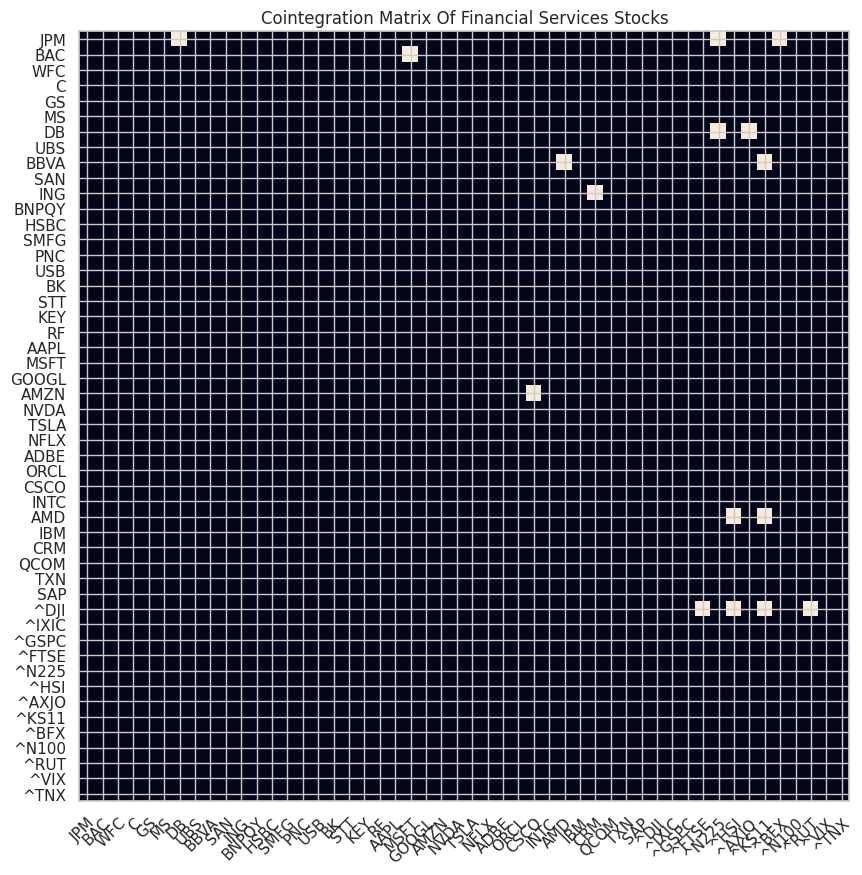

[('AAPL', 'BK'), ('AAPL', '^GSPC'), ('AAPL', '^N100'), ('ADBE', 'MSFT'), ('BK', '^GSPC'), ('BK', '^IXIC'), ('C', 'STT'), ('C', '^KS11'), ('CSCO', 'TXN'), ('NVDA', 'SAP'), ('STT', '^HSI'), ('STT', '^KS11'), ('^AXJO', '^FTSE'), ('^AXJO', '^HSI'), ('^AXJO', '^KS11'), ('^AXJO', '^RUT')]


In [284]:
# Plotting the cointegration matrix
fig, ax = plt.subplots(figsize=(40, 10))
im = ax.imshow(pvalues <= P_VALUE_THRESHOLD)

ax.set_xticks(np.arange(len(Tickers)))
ax.set_yticks(np.arange(len(Tickers)))
ax.set_xticklabels(Tickers)
ax.set_yticklabels(Tickers)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Cointegration Matrix Of Financial Services Stocks")
plt.show()
print(pairs)

## Heatmap for Cointegration
Visualizes cointegration between asset pairs using a heatmap. Cells indicate cointegration (p-value <= threshold).

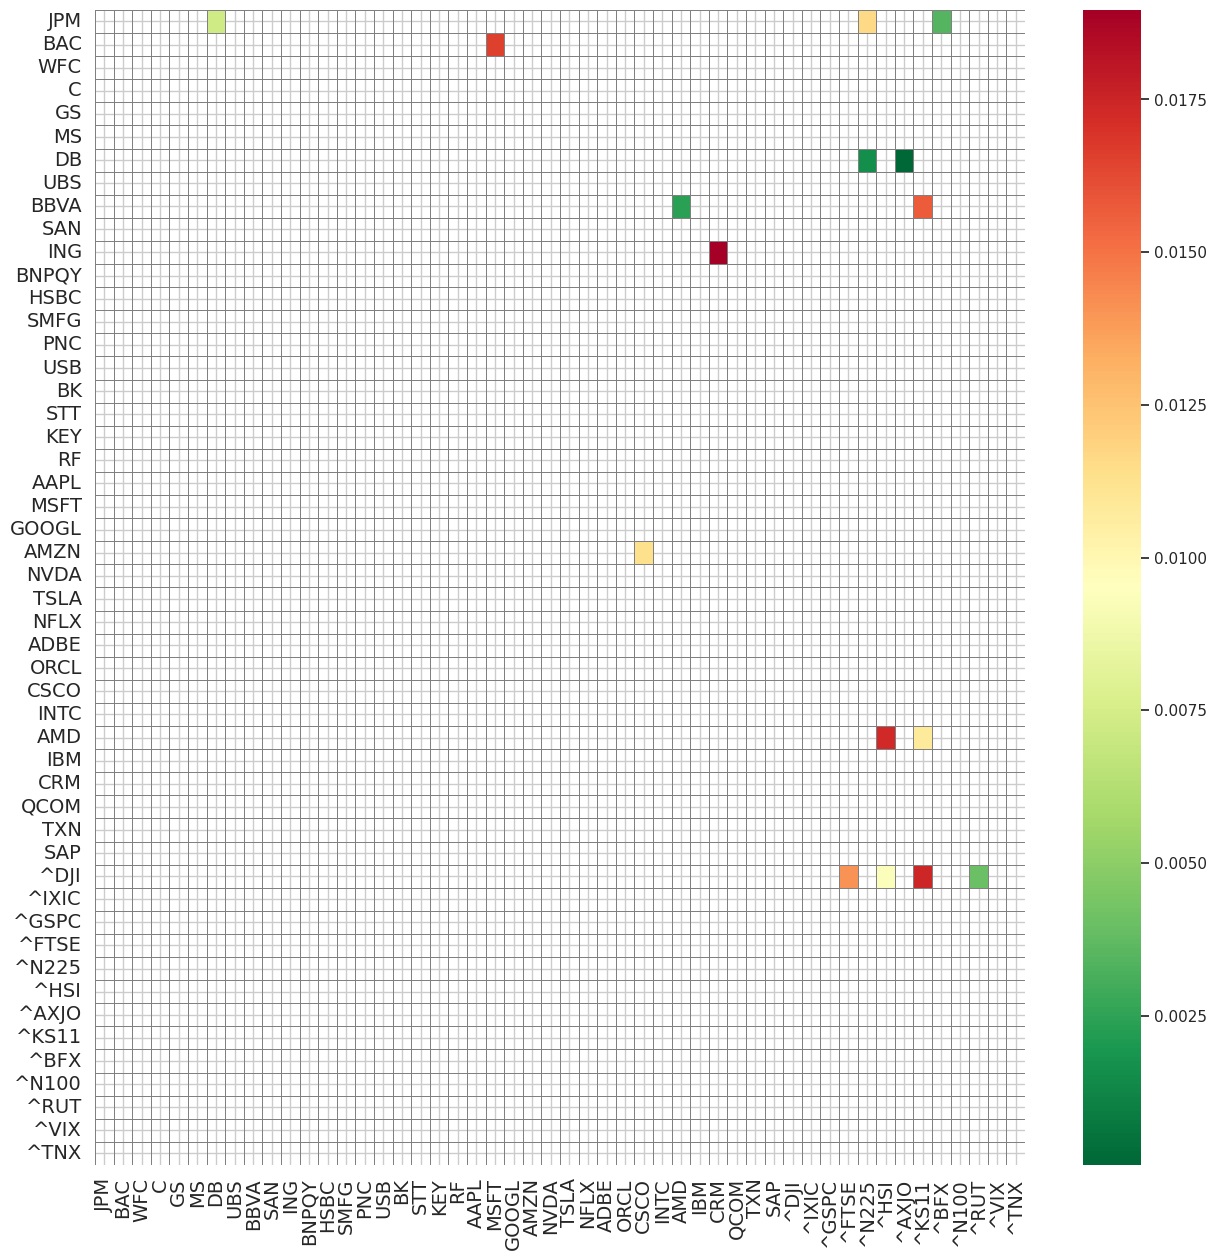

In [285]:
def plot_heatmap(pvalues, tickers):
    plt.figure(figsize=(15, 15))
    heatmap = sns.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues > (P_VALUE_THRESHOLD)), linecolor='gray', linewidths=0.5)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
    plt.show()

plot_heatmap(pvalues, Tickers)

## Price Comparison: State Street vs. Citigroup
Compares the price trends of State Street (STT) and Citigroup (C) in U.S. dollars.

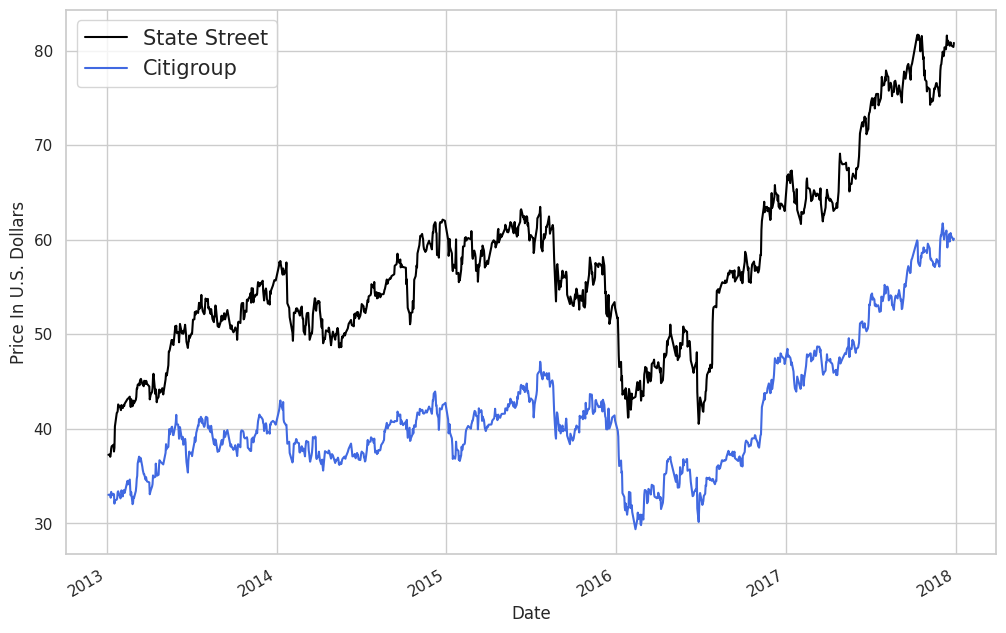

In [286]:
plt.figure(figsize=(12,8))
df['STT'].plot(color = 'black')
df['C'].plot(color = 'royalblue')
plt.legend(['State Street', 'Citigroup'], prop={'size': 15})
plt.ylabel('Price In U.S. Dollars')
plt.show()

## Cointegration Test: State Street and Citigroup
Performs an augmented Engle-Granger two-step cointegration test between State Street (STT) and Citigroup (C) for the first 252 days of data.


In [287]:
placeholder, pvalue, placeholder2 = coint(df['STT'][0:252], df['C'][0:252])
print("The pvalue of the augmented Engle-Granger two-step cointegration test between $C and $STT is", round(pvalue,5))


The pvalue of the augmented Engle-Granger two-step cointegration test between $C and $STT is 0.06695


## Spread Calculation and Plot
Calculates and plots the spread between Citigroup (C) and State Street (STT) stock prices using an OLS model.

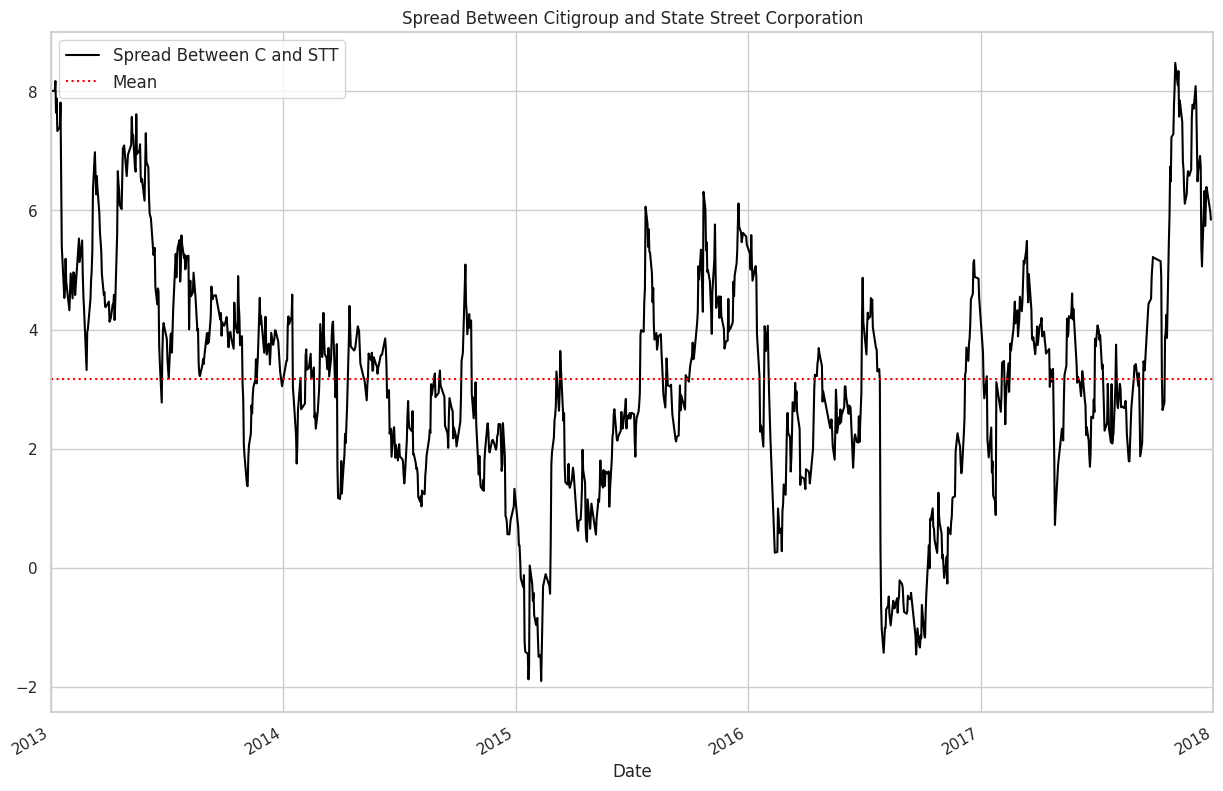

In [288]:
Asset_1 = df['STT']
Asset_2 =  df['C']

#calculating the spread
Asset_1  = add_constant(Asset_1)
results = OLS(Asset_2, Asset_1).fit()

coef = results.params['STT']
Asset_1 = Asset_1['STT']

spread = Asset_2 - (coef * Asset_1)

spread.plot(figsize=(15,10), color = 'black')
plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(spread.mean(), color='red', linestyle=':')
plt.legend(['Spread Between C and STT', 'Mean'], prop={'size': 12});
plt.title("Spread Between Citigroup and State Street Corporation")
plt.show()


## Price Ratio Z-Score Plot
Calculates and plots the Z-score of the price ratio between Citigroup and State Street, indicating deviations from the mean in terms of standard deviations.


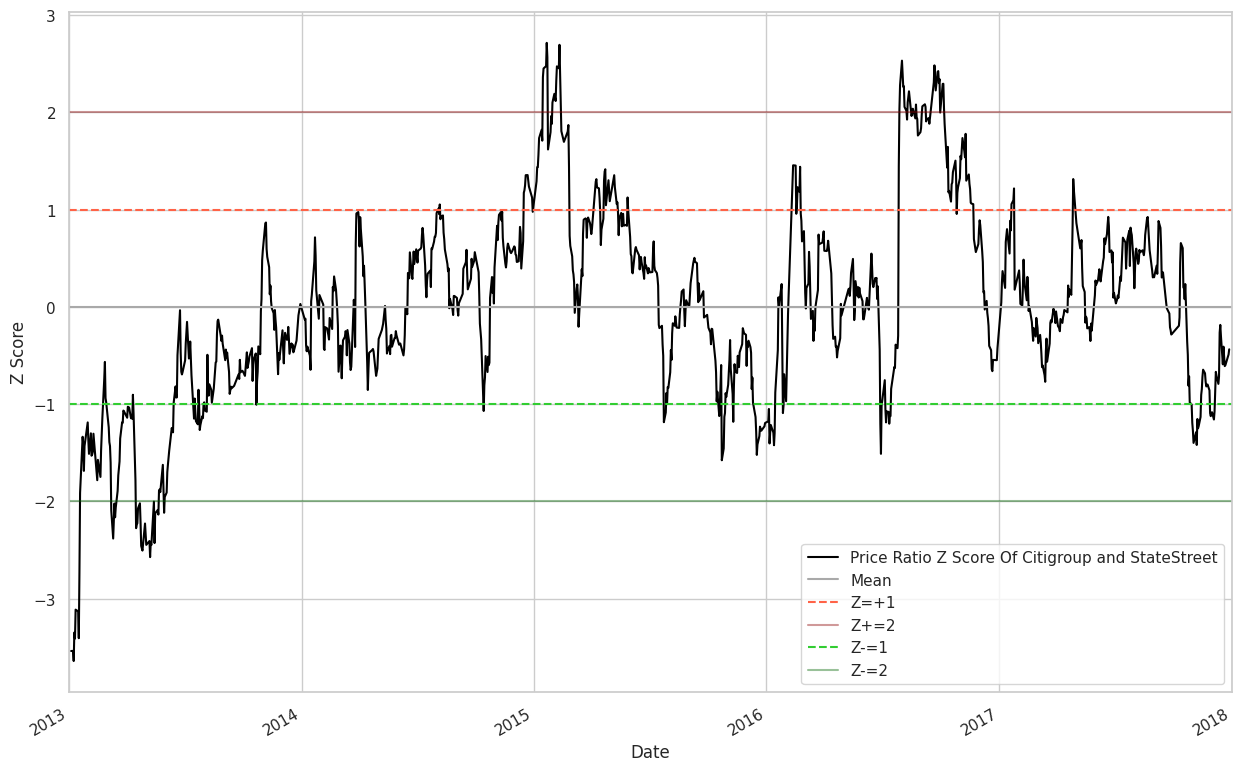

In [290]:
price_ratio_z_score = (price_ratio - price_ratio.mean()) / np.std(price_ratio)
# Z score formula:  (observed value -- mean of the sample) / standard deviation of the sample

price_ratio_z_score.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio_z_score.mean(), color = 'darkgrey' )
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(2, color='darkred', alpha = .4)
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.axhline(-2, color='darkgreen', alpha = .4)


plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio Z Score Of Citigroup and StateStreet', 'Mean', 'Z=+1', 'Z+=2', 'Z-=1', 'Z-=2' ]);
plt.ylabel('Z Score')

plt.show()

## Price Ratio and Moving Averages Plot
Calculates and plots the price ratio between State Street (STT) and Citigroup (C), along with its 10-day and 60-day moving averages.

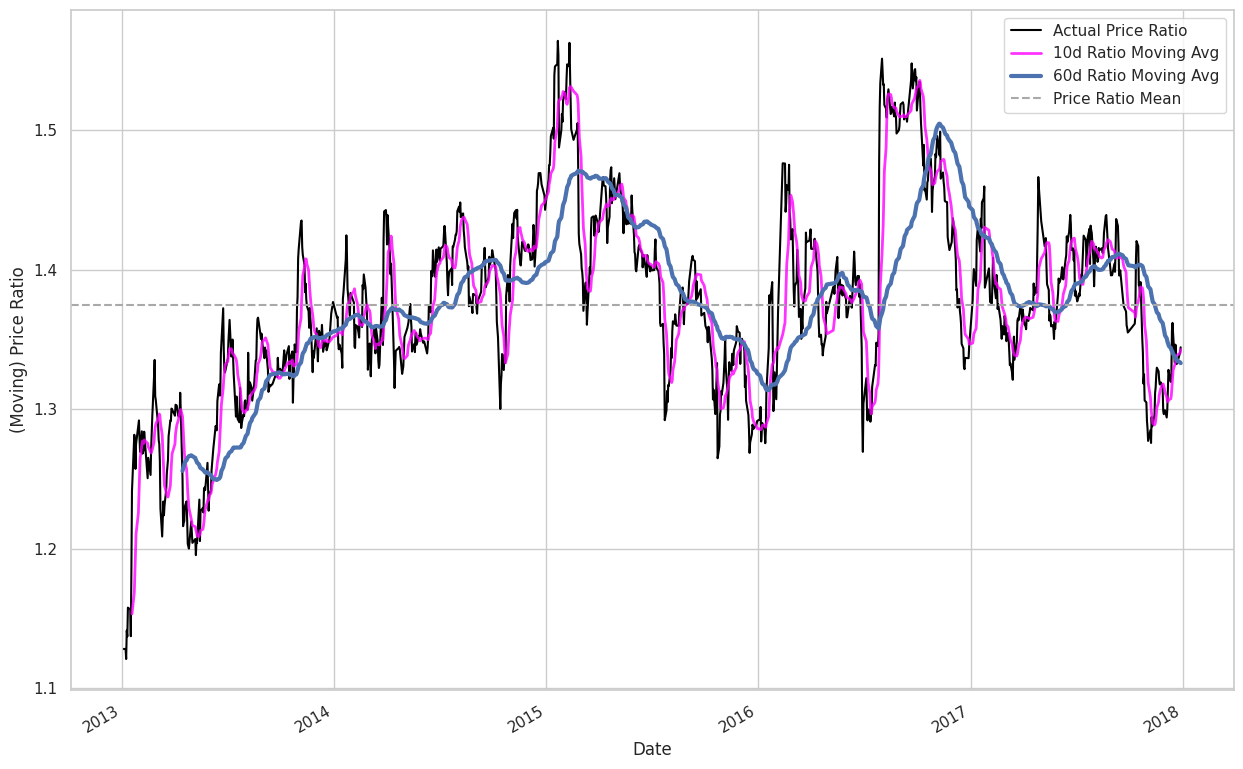

In [291]:
#price ratio = ($STT / $C)
price_ratio = Asset_1/Asset_2

price_ratio_10D_MAVG = price_ratio.rolling(window=10).mean()
price_ratio_60D_MAVG = price_ratio.rolling(window=60).mean()

plt.figure(figsize=(15, 10))
price_ratio.plot(color = 'black')
price_ratio_10D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
price_ratio_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(price_ratio.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '10d Ratio Moving Avg', '60d Ratio Moving Avg', 'Price Ratio Mean'])
plt.ylabel('(Moving) Price Ratio')
plt.show()

## Rolling Z-Score of Price Ratio
Calculates and plots the rolling Z-score of the price ratio between Citigroup and State Street using 10-day and 60-day moving averages.

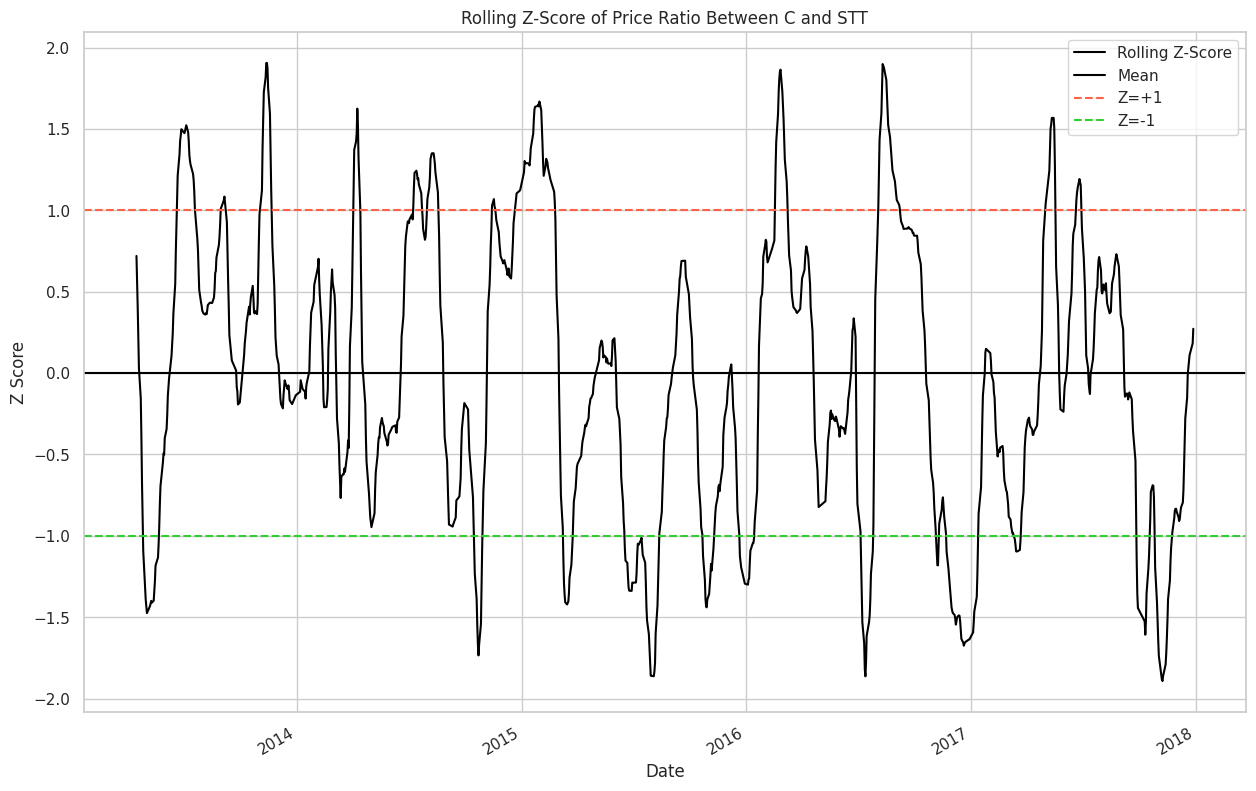

In [292]:
STD_60 = price_ratio.rolling(window=60).std()
Rolling_Z_Score = ((price_ratio_10D_MAVG - price_ratio_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

#plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title("Rolling Z-Score of Price Ratio Between C and STT")
plt.ylabel('Z Score')
plt.show()


## Price Ratio with Buy/Sell Signals
Plots the price ratio between Citigroup and State Street with buy and sell signals based on the rolling Z-score.

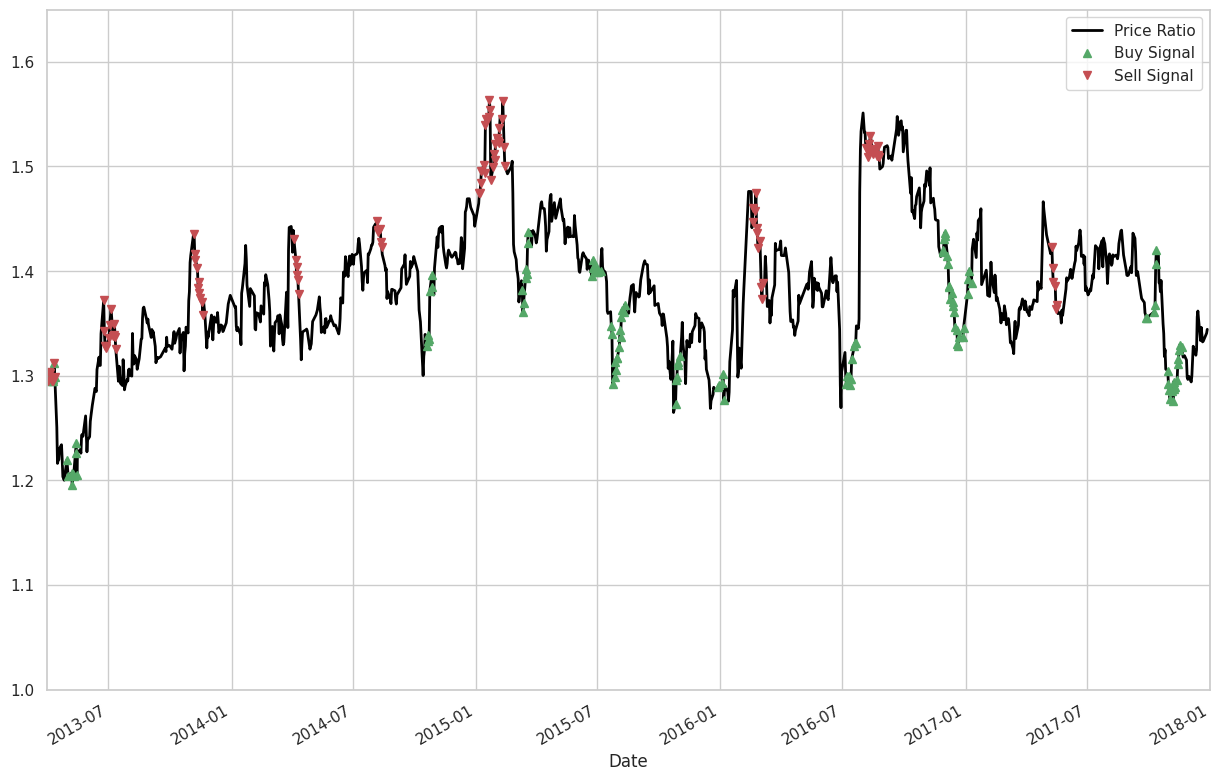

In [293]:
price_ratio.plot(figsize=(15,10), color = 'black', linewidth = 2)
buy  = price_ratio.copy()
sell = price_ratio.copy()


buy[Rolling_Z_Score > -1.25] = 0
buy.plot(color='g', linestyle='None', marker='^')


sell[Rolling_Z_Score < 1.25] = 0
sell.plot(color='r', linestyle='None', marker='v')


plt.axis(('2013-04-01','2018-01-01', 1, 1.65))

plt.legend(['Price Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()


## State Street vs. Citigroup Stock Prices
Plots the stock prices of State Street (STT) and Citigroup (C), along with the nominal price difference between them.

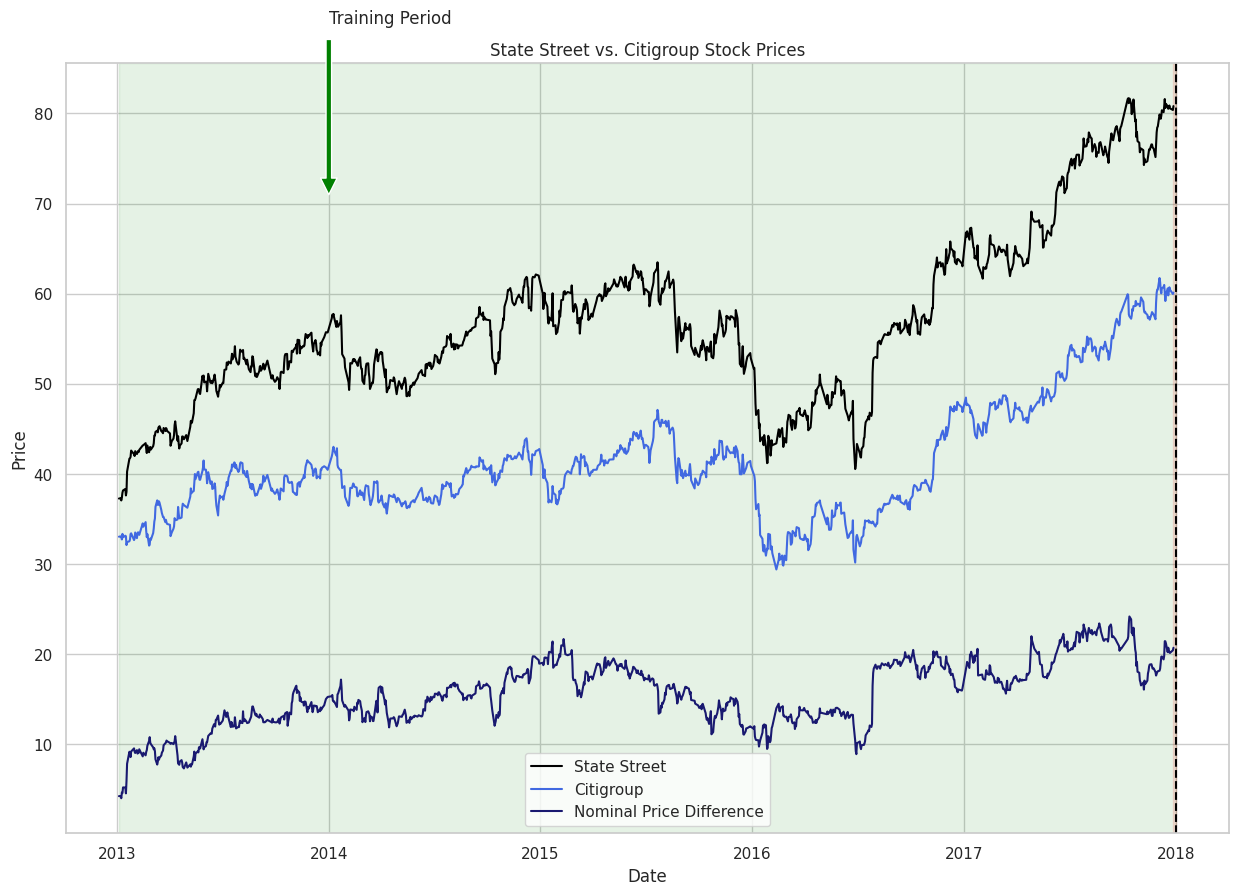

In [294]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['STT'], color='black', label='State Street')
plt.plot(df.index, df['C'], color='royalblue', label='Citigroup')
plt.plot(df.index, df['STT'] - df['C'], color='midnightblue', label='Nominal Price Difference')

# Highlighting training and testing periods
plt.axvline(x=pd.Timestamp('2018-01-01'), color='black', linestyle='--')
plt.axvspan(df.index[0], pd.Timestamp('2018-01-01'), alpha=0.1, color='green')
plt.axvspan(pd.Timestamp('2018-01-01'), df.index[-1], alpha=0.1, color='red')

# Adding legend and labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('State Street vs. Citigroup Stock Prices')

# Adding annotations
plt.annotate('Training Period', xy=(pd.Timestamp('2014-01-01'), 70), xytext=(pd.Timestamp('2014-01-01'), 90),
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate('Testing Period', xy=(pd.Timestamp('2019-01-01'), 70), xytext=(pd.Timestamp('2019-01-01'), 90),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.grid(True)
plt.show()


## Advanced Pairs Trading Strategy Simulation

This function `trading_simulation` implements a sophisticated pairs trading strategy between two assets (`Asset1` and `Asset2`). It computes moving averages and Z-scores of the price ratio, triggering buy/sell signals based on predefined conditions. It tracks trades, calculates equity curves, and provides a comprehensive set of performance metrics, including gross profit, net profit, win rate, maximum drawdown, Sharpe ratio, average holding duration, and cumulative returns. This simulation offers insights into the strategy's effectiveness and risk management.

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def trading_simulation(Asset1, Asset2, window1, window2, leverage, stop_loss):
    price_ratio = Asset1 / Asset2

    moving_average1 = price_ratio.rolling(window=window1).mean()
    moving_average2 = price_ratio.rolling(window=window2).mean()
    std = price_ratio.rolling(window=window2).std()

    z_score = (moving_average1 - moving_average2) / std

    profit, profit_high, profit_low = 0, 0, 0
    ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
    low_trade_total, high_trade_total = 0, 0
    count_high, count_low = 0, 0
    old_profit_high, old_profit_low = 0, 0
    high_hit_rate, low_hit_rate = [], []
    low_dic, high_dic = {}, {}
    Asset1_shares, Asset2_shares = 0, 0
    open_trade = 0
    potential_loss_high, potential_loss_low = 0, 0

    df = pd.DataFrame(index=Asset1.index)

    equity_curve = []
    cumulative_profit = 0

    for i in range(len(price_ratio)):
        if z_score[i] > 1.25 and open_trade == 0:
            Asset1_shares = (leverage // 2) // Asset1[i]
            Asset2_shares = (leverage // 2) // Asset2[i]
            ratio_high_sell = Asset1[i] * Asset1_shares
            ratio_high_buy = Asset2[i] * Asset2_shares
            count_high += 1
            high_trade_total += 1
            open_trade = 1
        elif z_score[i] < -1.25 and open_trade == 0:
            Asset1_shares = (leverage // 2) // Asset1[i]
            Asset2_shares = (leverage // 2) // Asset2[i]
            ratio_low_buy = Asset1[i] * Asset1_shares
            ratio_low_sell = Asset2[i] * Asset2_shares
            count_low += 1
            low_trade_total += 1
            open_trade = 1

        if open_trade == 1 and (abs(z_score[i]) > 0.5):
            potential_loss_high = ((ratio_high_sell - (Asset1[i] * Asset1_shares * count_high)) + ((Asset2[i] * Asset2_shares * count_high) - ratio_high_buy))
            potential_loss_low = (((Asset1[i] * Asset1_shares * count_low) - ratio_low_buy) + (ratio_low_sell - (Asset2[i] * Asset2_shares * count_low)))

            if potential_loss_high < -stop_loss or potential_loss_low < -stop_loss:
                old_profit_high = profit_high
                old_profit_low = profit_low

                profit_high += ratio_high_sell - (Asset1[i] * Asset1_shares * count_high)
                profit_high += (Asset2[i] * Asset2_shares * count_high) - ratio_high_buy

                if (profit_high - old_profit_high) != 0:
                    high_hit_rate.append(profit_high - old_profit_high)
                    high_dic[Asset1.index[i]] = (profit_high - old_profit_high)*10

                profit_low += (Asset1[i] * Asset1_shares * count_low) - ratio_low_buy
                profit_low += ratio_low_sell - (Asset2[i] * Asset2_shares * count_low)

                if (profit_low - old_profit_low) != 0:
                    low_hit_rate.append(profit_low - old_profit_low)
                    low_dic[Asset1.index[i]] = (profit_low - old_profit_low)*10

                ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
                count_high, count_low = 0, 0
                open_trade = 0

        elif (abs(z_score[i]) < 0.5):
            old_profit_high = profit_high
            old_profit_low = profit_low

            profit_high += ratio_high_sell - (Asset1[i] * Asset1_shares * count_high)
            profit_high += (Asset2[i] * Asset2_shares * count_high) - ratio_high_buy

            if (profit_high - old_profit_high) != 0:
                high_hit_rate.append(profit_high - old_profit_high)
                high_dic[Asset1.index[i]] = (profit_high - old_profit_high)*10

            profit_low += (Asset1[i] * Asset1_shares * count_low) - ratio_low_buy
            profit_low += ratio_low_sell - (Asset2[i] * Asset2_shares * count_low)

            if (profit_low - old_profit_low) != 0:
                low_hit_rate.append(profit_low - old_profit_low)
                low_dic[Asset1.index[i]] = (profit_low - old_profit_low)*10

            ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
            count_high, count_low = 0, 0
            open_trade = 0

        # Calculate cumulative profit
        cumulative_profit += profit_low + profit_high
        equity_curve.append(cumulative_profit)

    if len(high_hit_rate) > 0:
        high_biggest_loss = min(high_hit_rate)
        high_biggest_gain = max(high_hit_rate)
    else:
        high_biggest_loss = 0
        high_biggest_gain = 0

    if len(low_hit_rate) > 0:
        low_biggest_loss = min(low_hit_rate)
        low_biggest_gain = max(low_hit_rate)
    else:
        low_biggest_loss = 0
        low_biggest_gain = 0

    # Combine high and low trade dictionaries
    trades_dic = {**high_dic, **low_dic}

    # Prepare tracker for cumulative profits
    tracker = []
    total = leverage
    for key, value in sorted(trades_dic.items()):
        total += value
        tracker.append(total)

    trades = pd.DataFrame({'Date': list(trades_dic.keys()), 'Profit': list(trades_dic.values())})
    growth_tracker = pd.DataFrame({'Date': sorted(list(trades_dic.keys())), 'Cumulative Value': tracker})
    growth_tracker = growth_tracker.set_index('Date')

    # Calculate Sharpe Ratio
    daily_returns = growth_tracker['Cumulative Value'].pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std()) if daily_returns.std() != 0 else 0

    # Calculate Maximum Drawdown
    cumulative_growth = growth_tracker['Cumulative Value']
    rolling_max = cumulative_growth.cummax()
    drawdown = (cumulative_growth - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Calculate Average Holding Duration
    trades_dates = trades['Date']
    trades_diff = pd.to_datetime(trades_dates.shift(-1)) - pd.to_datetime(trades_dates)
    average_holding_duration = trades_diff.mean().days if not trades_diff.empty else 0

    # Calculate the overall cumulative return of the strategy
    initial_value = leverage
    final_value = growth_tracker['Cumulative Value'].iloc[-1]
    cumulative_return = (final_value - initial_value) / initial_value

    # Calculate Win Rate
    win_rate = (len(trades[trades['Profit'] > 0]) / len(trades)) * 100 if len(trades) > 0 else 0.0

    # Gross Profit
    gross_profit = sum([value for value in trades_dic.values() if value > 0])

    # Net Profit
    net_profit = gross_profit - abs(sum([value for value in trades_dic.values() if value < 0]))

    # Total Closed Trades
    total_closed_trades = len(trades_dic)*10

    # Gross Loss
    gross_loss = sum([value for value in trades_dic.values() if value < 0])

    # Average Winning Trade
    avg_winning_trade = sum([value for value in trades_dic.values() if value > 0]) / len([value for value in trades_dic.values() if value > 0]) if len([value for value in trades_dic.values() if value > 0]) > 0 else 0

    # Average Losing Trade
    avg_losing_trade = sum([value for value in trades_dic.values() if value < 0]) / len([value for value in trades_dic.values() if value < 0]) if len([value for value in trades_dic.values() if value < 0]) > 0 else 0

    # Buy and Hold Return
    buy_and_hold_return = growth_tracker['Cumulative Value'][-1] - growth_tracker['Cumulative Value'][0] if len(growth_tracker) > 0 else 0

    # Largest Losing Trade
    largest_losing_trade = min(trades_dic.values()) if len(trades_dic.values()) > 0 else 0

    # Largest Winning Trade
    largest_winning_trade = max(trades_dic.values()) if len(trades_dic.values()) > 0 else 0

    # Plot the Equity Curve
    plt.figure(figsize=(12, 6))
    plt.plot(growth_tracker.index, growth_tracker['Cumulative Value'], label='Equity Curve')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.legend()
    plt.show()

    return {
        'Gross Profit': gross_profit,
        'Net Profit': net_profit,
        'Total Closed Trades': total_closed_trades,
        'Win Rate(%)': win_rate,
        'Max Drawdown': max_drawdown,
        'Gross Loss': gross_loss,
        'Average Winning Trade': avg_winning_trade,
        'Average Losing Trade': avg_losing_trade,
        'Buy and Hold Return': buy_and_hold_return,
        'Largest Losing Trade': largest_losing_trade,
        'Largest Winning Trade': largest_winning_trade,
        'Sharpe Ratio': sharpe_ratio,
        'Average Holding Duration': average_holding_duration,
        'Cumulative Returns(%)': cumulative_return*100,
    }


- **Gross Profit**: Total profit before deducting expenses.
- **Net Profit**: Profit after deducting expenses.
- **Total Closed Trades**: Number of trades executed.
- **Win Rate(%):** Percentage of trades that were profitable.
- **Max Drawdown**: Maximum loss from a peak to a trough.
- **Gross Loss**: Total loss before deducting expenses.
- **Average Winning Trade**: Average profit from profitable trades.
- **Average Losing Trade**: Average loss from losing trades.
- **Buy and Hold Return**: Return from simply holding the assets.
- **Largest Losing Trade**: Biggest loss from a single trade.
- **Largest Winning Trade**: Biggest profit from a single trade.
- **Sharpe Ratio**: Measure of risk-adjusted return.
- **Average Holding Duration**: Average duration of trades.
- **Cumulative Returns(%)**: Overall return as a percentage.

- **Equity Curve**: Graphical representation of the cumulative value of the trading strategy over time, showing growth and drawdowns, provides visual insights into the performance and volatility of the trading strategy, aiding in decision-making and strategy refinement.

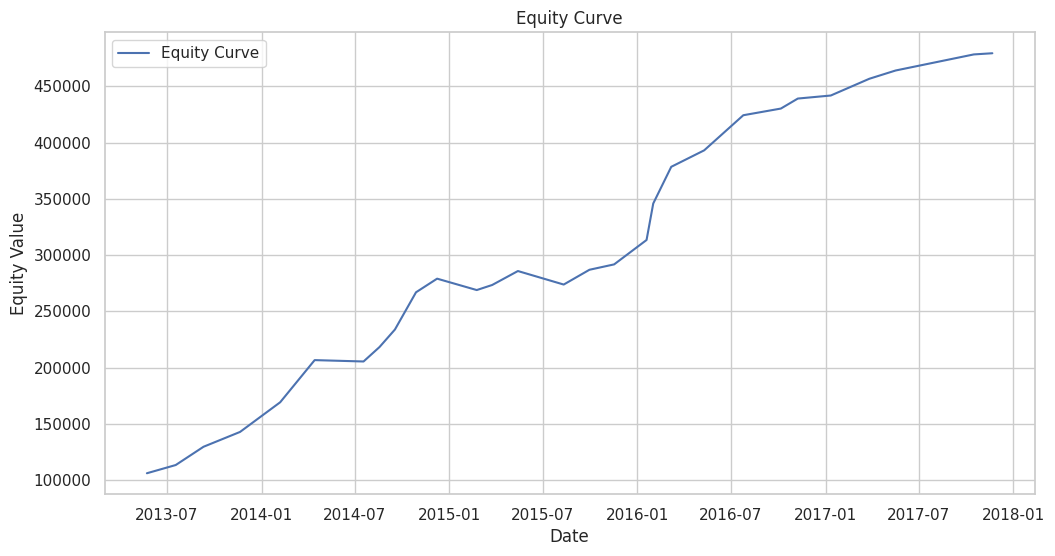

{'Gross Profit': 402698.71339797974,
 'Net Profit': 379343.5153388977,
 'Total Closed Trades': 290,
 'Win Rate(%)': 89.65517241379311,
 'Max Drawdown': -0.04201100773006495,
 'Gross Loss': -23355.19805908203,
 'Average Winning Trade': 15488.412053768452,
 'Average Losing Trade': -7785.066019694011,
 'Buy and Hold Return': 373172.2140312195,
 'Largest Losing Trade': -12008.403244018555,
 'Largest Winning Trade': 37455.83053588867,
 'Sharpe Ratio': 14.679054508944752,
 'Average Holding Duration': 56,
 'Cumulative Returns(%)': 379.3435153388977}

In [320]:
#'in-sample'
trading_simulation(df['STT'], df['C'], 5, 40, 100000, 5000)

## Trading Signals for State Street (STT) and Citigroup (C)
Plots the stock prices of State Street (STT) and Citigroup (C), highlighting buy (green) and sell (red) signals based on the pairs trading strategy.

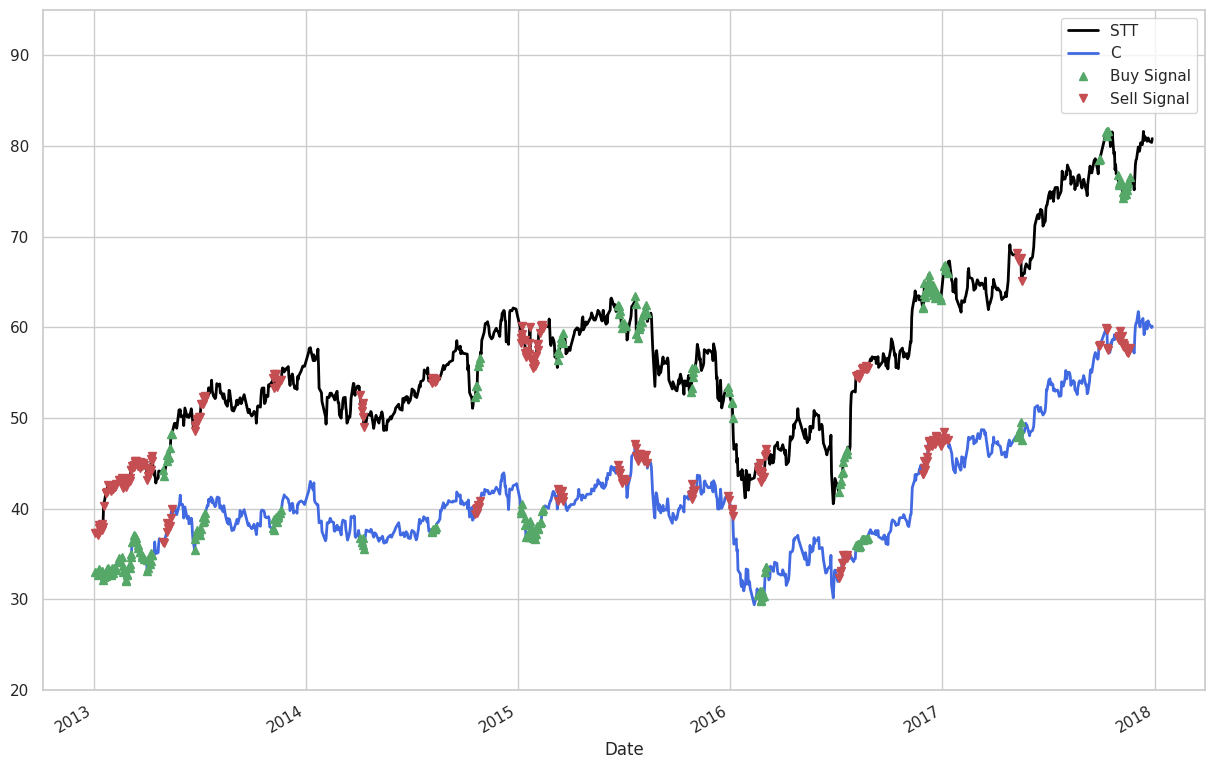

In [313]:
plt.figure(figsize=(15,10))
Asset_1 = df['STT']
Asset_2 = df['C']

Asset_1.plot(color='black', linewidth=2)
Asset_2.plot(color='royalblue', linewidth=2)

Buy_The_Ratio = 0*Asset_1.copy()
Sell_The_Ratio = 0*Asset_1.copy()
#creating blank dfs for our order instructions


# 'buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
Buy_The_Ratio[buy!=0] = Asset_1[buy!=0]
Buy_The_Ratio[sell!=0] = Asset_2[sell!=0]

# 'selling' the ratio means you sell the higher stock (STT) and buy the lower stock (C)
Sell_The_Ratio[buy!=0] = Asset_2[buy!=0]
Sell_The_Ratio[sell!=0] = Asset_1[sell!=0]


Buy_The_Ratio.plot(color='g', linestyle='None', marker='^')
Sell_The_Ratio.plot(color='r', linestyle='None', marker='v')

plt.legend(['STT', 'C', 'Buy Signal', 'Sell Signal'])

plt.ylim([20,95])

plt.show()